# Text classification with Pytorch

The goal of this lab is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to the **20Newsgroup dataset** - that we will get from ```scikit-learn```.

In [1]:
import torch
import torch.nn as nn

## 1 - A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [2]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([0, 0, 0, 0, 0])
tensor([5])


In [3]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).


In [4]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [5]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.3231, -0.4527, -0.3197],
        [ 0.3695, -0.2339, -0.5739]], requires_grad=True)
bias
Parameter containing:
tensor([-0.5461,  0.5322], requires_grad=True)
Initial loss:  0.7042767405509949
dL/dw:  tensor([[ 0.0629,  0.0177, -0.1888],
        [ 0.3480, -0.0879, -0.1363]])
dL/db:  tensor([-0.3275,  0.2936])


In [6]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  0.700491726398468


In [7]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  0.6967955827713013


## 2 - Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [8]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [10]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [11]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [12]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [13]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walked down the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard', 'i walk down the the avenue'); labels: tensor([1, 0])
Batch: ('i walked down down the boulevard',); labels: tensor([0])
Epoch:1
Batch: ('i walked down the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard', 'i walked down down the boulevard'); labels: tensor([1, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])
Epoch:2
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])


## 3 - Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [14]:
import os
import sys
import os.path as op
from torch.nn import functional as F
import numpy as np
import random
from pprint import pprint

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torch.nn.utils.rnn import pad_sequence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First, we get the data: 

In [15]:
ng_train = fetch_20newsgroups(subset='train',
                              remove=('headers', 'footers', 'quotes')
                              )

In [16]:
pprint(dir(ng_train))
pprint(ng_train.target_names)

['DESCR', 'data', 'filenames', 'target', 'target_names']
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Example of one document:

In [17]:
pprint(ng_train.data[0])
print("Target: ", ng_train.target_names[ng_train.target[0]])

('I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.')
Target:  rec.autos


In [18]:
ng_test = fetch_20newsgroups(subset='test',
                             remove=('headers', 'footers', 'quotes')
                            )

Let's focus on ***tokenizing*** this data and **removing empty documents**:
<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
ng_train_text = [text for text in ng_train.data if text.strip() != ""]
ng_train_labels = [ng_train.target[i] for i, text in enumerate(ng_train.data) if text.strip() != ""]

In [20]:
ng_test_text = [text for text in ng_test.data if text.strip() != ""]
ng_test_labels = [ng_test.target[i] for i, text in enumerate(ng_test.data) if text.strip() != ""]

We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:



In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(ng_train_text, ng_train_labels, test_size=.2)
test_texts, test_labels = ng_test_text, ng_test_labels

We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [23]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [24]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


<div class='alert alert-block alert-info'>
            Code:</div>

In [25]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 200, count_threshold = 10000):
        self.data = data      
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, count_threshold)
        
        # We then need to tokenize the data .. 
        tokenized_data = [nltk.word_tokenize(text.lower()) for text in self.data]# To complete
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [
            [
                self.word2idx.get(word, self.word2idx["UNK"]) 
                for word in tokens
            ]
            for tokens in tokenized_data
        ] # To complete
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(idx_list) for idx_list in indexed_data]# To complete
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)# To complete
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:self.max_length] for tensor in tensor_data] # To complete
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0) # To complete
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the first TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        from collections import Counter
        token_counter = Counter()
        for text in corpus:
            tokens = nltk.word_tokenize(text.lower())
            token_counter.update(tokens)
        word_index = {}
        idx_word = {}
        word_index['UNK'] = 1
        idx_word[1] = 'UNK'
        idx = 2
        for word, count in token_counter.items():
            if count >= count_threshold:
                word_index[word] = idx
                idx_word[idx] = word
                idx += 1
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
training_dataset = TextClassificationDataset(train_texts_splt, train_labels_splt)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [28]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))

In [29]:
test_dataset = TextClassificationDataset(test_texts, test_labels, (training_word2idx, training_idx2word))

In [30]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [31]:
print(valid_dataset[1])

(tensor([ 3,  1,  4,  1,  5,  1,  1,  1,  5,  1,  1,  1, 34,  5,  1,  4,  1,  1,
        13, 14,  5,  1, 16,  1,  1,  8,  1, 13,  1,  1,  1, 39,  1, 36, 36,  1,
         1,  1, 39,  1, 11,  1, 16,  1,  1, 12,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]), tensor(11.))


In [32]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 200])
torch.Size([200])


### 4 - A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

<div class='alert alert-block alert-info'>
            Code:</div>

In [33]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):
    
    def __init__(self, embedding_dim, vocabulary_size, categories_num):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)  # To complete
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, categories_num)  # To complete
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs).mean(1)  # To complete
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()  # To complete
        return o

In [34]:
import torch.optim as optim

In [35]:
model = AveragingModel(300, len(training_word2idx), max(ng_train_labels)+1)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits, 
# meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

In [36]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)# To complete
        # Ensure y is of type LongTensor (as required by CrossEntropyLoss)
        if y.dtype != torch.long:
            y = y.long()
        # (2) Compute the loss 
        loss = criterion(pred, y) # To complete
        # (3) Compute gradients with the criterion
        loss.backward() # To complete
        # (4) Update weights with the optimizer
        opt.step() # To complete
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        num_corrects = (pred.argmax(1) == y).sum() # To complete
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

In [37]:
# Same for the evaluation ! We don't need the optimizer here. 

def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x) # To complete
            # Ensure y is of type LongTensor (as required by CrossEntropyLoss)
            if y.dtype != torch.long:
                y = y.long()
            loss = criterion(pred, y) # To complete
            num_corrects = (pred.argmax(1) == y).sum()# To complete
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [38]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary.

def experiment(model, opt, criterion, num_epochs = 10, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [39]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 3.042581558227539; training acc = 7.5
Batch 20 : training loss = 3.0028908252716064; training acc = 8.5
Batch 40 : training loss = 2.9763803482055664; training acc = 5.5
Epoch 1 : Validation loss = 2.9704512424683305; Validation acc = 6.696629213483146
Epoch 2:
Batch 0 : training loss = 3.0033044815063477; training acc = 8.0
Batch 20 : training loss = 2.9844870567321777; training acc = 7.5
Batch 40 : training loss = 2.94541597366333; training acc = 9.0
Epoch 2 : Validation loss = 2.931492668859075; Validation acc = 11.640449438202246
Epoch 3:
Batch 0 : training loss = 2.9135842323303223; training acc = 11.0
Batch 20 : training loss = 2.8648977279663086; training acc = 12.5
Batch 40 : training loss = 2.8458261489868164; training acc = 16.5
Epoch 3 : Validation loss = 2.9068520256642545; Validation acc = 11.280898876404494
Epoch 4:
Batch 0 : training loss = 2.890129804611206; training acc = 15.5
Batch 20 : training loss = 2.8599829

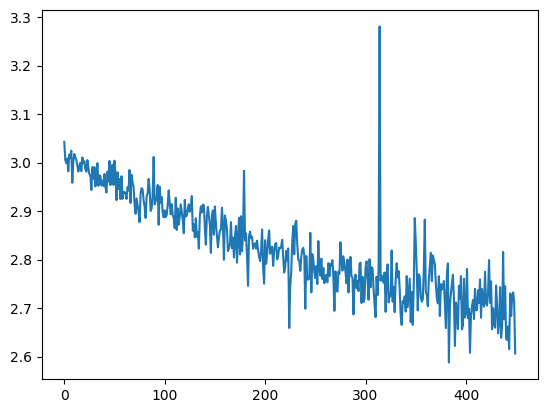

In [40]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

<div class='alert alert-block alert-info'>
            Code:</div>

In [41]:
# Implement a function allowing to use scikit-learn's evaluation functions for classification 
# (classification report, confusion matrix)
# on our model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def eval_model_report(model, evalloader):
    model.eval()  
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for i, (x, y) in enumerate(evalloader):
            x = x.to(next(model.parameters()).device)
            y = y.cpu().numpy()
            pred = model(x)
            if pred.shape[-1] == 1:
                # Binary classification (logistic output)
                output = (pred.sigmoid() > 0.5).long().cpu().numpy().flatten()
            else:
                # Multi-class classification (softmax output)
                output = pred.argmax(dim=1).cpu().numpy().flatten()
            all_preds.extend(output)
            all_labels.extend(y)
                     
    report = classification_report(all_labels, all_preds)# To complete
    cm = confusion_matrix(all_labels, all_preds) # To complete
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print(report)
    disp.plot()

c:\Users\MSI\Desktop\Atef Master\Master2-SD-IPP\masterenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\Desktop\Atef Master\Master2-SD-IPP\masterenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\Desktop\Atef Master\Master2-SD-IPP\masterenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

              precision    recall  f1-score   support

         0.0       0.11      0.05      0.06       311
         1.0       0.04      0.01      0.02       384
         2.0       0.08      0.11      0.10       379
         3.0       0.15      0.23      0.18       386
         4.0       0.22      0.05      0.08       371
         5.0       0.17      0.12      0.14       391
         6.0       0.35      0.73      0.47       382
         7.0       0.09      0.06      0.07       375
         8.0       0.11      0.01      0.02       386
         9.0       0.08      0.23      0.12       383
        10.0       0.18      0.26      0.21       390
        11.0       0.10      0.25      0.14       380
        12.0       0.19      0.04      0.07       383
        13.0       0.07      0.04      0.05       382
        14.0       0.12      0.05      0.07       378
        15.0       0.19      0.27      0.22       384
        16.0       0.00      0.00      0.00       354
        17.0       0.18    

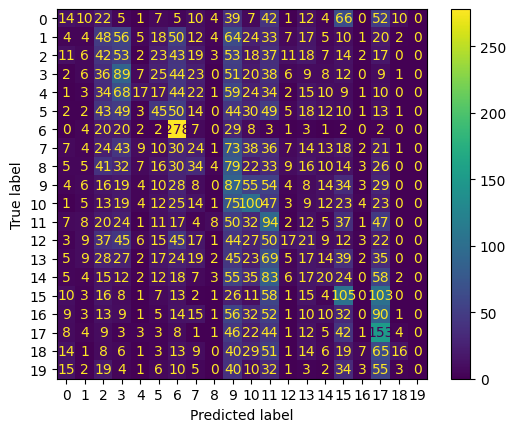

In [42]:
eval_model_report(model, test_dataloader)

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous lab:

In [43]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [44]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [45]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(45, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [46]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, categories_num, pretrained_embeddings=None, fine_tuning=True):
        super().__init__()
        
        if pretrained_embeddings is not None:
            # Use pretrained embeddings
            self.embeddings = nn.Embedding.from_pretrained(
                torch.FloatTensor(pretrained_embeddings), 
                padding_idx=0,
                freeze=not fine_tuning
            )
        else:
            # Random initialization
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        self.linear = nn.Linear(embedding_dim, categories_num)
        
    def forward(self, inputs):
        x = self.embeddings(inputs).mean(dim=1)
        o = self.linear(x)
        return o

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how the size of the vocabulary (change the minimum frequency of words to be taken in the vocabular) will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify experiments and analyze your results ! Look at the detailed performance using dedicated function.

> **Answer**

**Question 1: Results with and without fine-tuning of GloVe embeddings**

Let me implement comprehensive experiments to answer this question:


In [47]:
# Experiment 1: Compare different embedding approaches
import time

def run_experiment_comparison():
    """Run experiments comparing different embedding approaches"""
    results = {}
    
    # 1. Random embeddings (no pre-training)
    print("=== Experiment 1: Random Embeddings (No Pre-training) ===")
    model_random = AveragingModel(300, len(training_word2idx), max(ng_train_labels)+1)
    opt_random = optim.Adam(model_random.parameters(), lr=0.0025)
    criterion = nn.CrossEntropyLoss()
    
    start_time = time.time()
    train_losses_random = experiment(model_random, opt_random, criterion, num_epochs=5, early_stopping=False)
    test_loss_random, test_acc_random = eval_model(model_random, criterion, test_dataloader)
    training_time_random = time.time() - start_time
    
    results['random'] = {
        'test_accuracy': test_acc_random,
        'test_loss': test_loss_random,
        'training_time': training_time_random
    }
    
    # 2. GloVe embeddings without fine-tuning
    print("\n=== Experiment 2: GloVe Embeddings (No Fine-tuning) ===")
    model_glove_frozen = PretrainedAveragingModel(300, len(training_word2idx), max(ng_train_labels)+1, 
                                                 GloveEmbeddings, fine_tuning=False)
    opt_glove_frozen = optim.Adam(model_glove_frozen.parameters(), lr=0.0025)
    
    start_time = time.time()
    train_losses_glove_frozen = experiment(model_glove_frozen, opt_glove_frozen, criterion, num_epochs=5, early_stopping=False)
    test_loss_glove_frozen, test_acc_glove_frozen = eval_model(model_glove_frozen, criterion, test_dataloader)
    training_time_glove_frozen = time.time() - start_time
    
    results['glove_frozen'] = {
        'test_accuracy': test_acc_glove_frozen,
        'test_loss': test_loss_glove_frozen,
        'training_time': training_time_glove_frozen
    }
    
    # 3. GloVe embeddings with fine-tuning
    print("\n=== Experiment 3: GloVe Embeddings (With Fine-tuning) ===")
    model_glove_tuned = PretrainedAveragingModel(300, len(training_word2idx), max(ng_train_labels)+1, 
                                                GloveEmbeddings, fine_tuning=True)
    opt_glove_tuned = optim.Adam(model_glove_tuned.parameters(), lr=0.0025)
    
    start_time = time.time()
    train_losses_glove_tuned = experiment(model_glove_tuned, opt_glove_tuned, criterion, num_epochs=5, early_stopping=False)
    test_loss_glove_tuned, test_acc_glove_tuned = eval_model(model_glove_tuned, criterion, test_dataloader)
    training_time_glove_tuned = time.time() - start_time
    
    results['glove_tuned'] = {
        'test_accuracy': test_acc_glove_tuned,
        'test_loss': test_loss_glove_tuned,
        'training_time': training_time_glove_tuned
    }
    
    return results

# Run the experiments
experiment_results = run_experiment_comparison()


=== Experiment 1: Random Embeddings (No Pre-training) ===
Beginning training...
Epoch 1:
Batch 0 : training loss = 3.0374677181243896; training acc = 4.0
Batch 20 : training loss = 2.9726128578186035; training acc = 6.0
Batch 40 : training loss = 2.9967169761657715; training acc = 5.0
Epoch 1 : Validation loss = 2.978457059753075; Validation acc = 6.876404494382022
Epoch 2:
Batch 0 : training loss = 2.9712400436401367; training acc = 7.5
Batch 20 : training loss = 2.9172093868255615; training acc = 8.0
Batch 40 : training loss = 2.9316201210021973; training acc = 10.0
Epoch 2 : Validation loss = 2.933924608016282; Validation acc = 10.786516853932584
Epoch 3:
Batch 0 : training loss = 2.941429853439331; training acc = 8.0
Batch 20 : training loss = 2.911764144897461; training acc = 14.0
Batch 40 : training loss = 2.9355251789093018; training acc = 10.5
Epoch 3 : Validation loss = 2.9085210253683367; Validation acc = 12.134831460674157
Epoch 4:
Batch 0 : training loss = 2.867800712585449

In [48]:
# Display results comparison
print("=== EMBEDDING APPROACH COMPARISON ===")
print(f"{'Approach':<20} {'Test Accuracy':<15} {'Test Loss':<12} {'Training Time':<15}")
print("-" * 70)

for approach, results in experiment_results.items():
    approach_name = {
        'random': 'Random Embeddings',
        'glove_frozen': 'GloVe (Frozen)',
        'glove_tuned': 'GloVe (Fine-tuned)'
    }[approach]
    
    print(f"{approach_name:<20} {results['test_accuracy']:<15.2f} {results['test_loss']:<12.4f} {results['training_time']:<15.2f}")


=== EMBEDDING APPROACH COMPARISON ===
Approach             Test Accuracy   Test Loss    Training Time  
----------------------------------------------------------------------
Random Embeddings    13.81           2.8308       3.52           
GloVe (Frozen)       11.03           2.9199       2.03           
GloVe (Fine-tuned)   14.90           2.7813       3.48           


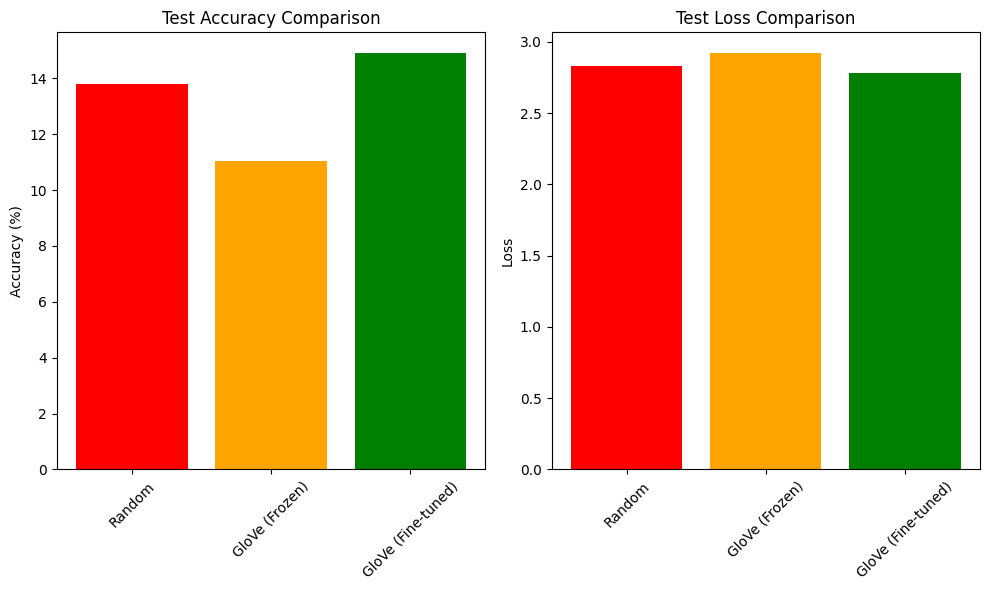

In [49]:
import matplotlib.pyplot as plt

approaches = ['Random', 'GloVe (Frozen)', 'GloVe (Fine-tuned)']
accuracies = [experiment_results['random']['test_accuracy'], 
              experiment_results['glove_frozen']['test_accuracy'], 
              experiment_results['glove_tuned']['test_accuracy']]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(approaches, accuracies, color=['red', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
losses = [experiment_results['random']['test_loss'], 
          experiment_results['glove_frozen']['test_loss'], 
          experiment_results['glove_tuned']['test_loss']]
plt.bar(approaches, losses, color=['red', 'orange', 'green'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [50]:
# Experiment 2: Vocabulary size impact analysis
def run_vocabulary_size_experiments():
    """Test the impact of vocabulary size (min_freq parameter) on different approaches"""
    min_freqs = [1, 5, 10, 50, 100]  # Different minimum frequency thresholds
    vocab_results = {}
    
    for min_freq in min_freqs:
        print(f"\n=== Testing min_freq = {min_freq} ===")
        
        # Create new datasets with different vocabulary sizes
        train_dataset_vocab = TextClassificationDataset(train_texts_splt, train_labels_splt, 
                                                       max_length=200, count_threshold=min_freq)
        train_word2idx_vocab, train_idx2word_vocab = train_dataset_vocab.get_vocab()
        
        val_dataset_vocab = TextClassificationDataset(val_texts, val_labels, 
                                                       (train_word2idx_vocab, train_idx2word_vocab))
        test_dataset_vocab = TextClassificationDataset(test_texts, test_labels, 
                                                       (train_word2idx_vocab, train_idx2word_vocab))
        
        # Create dataloaders
        train_loader_vocab = DataLoader(train_dataset_vocab, batch_size=200, shuffle=True)
        val_loader_vocab = DataLoader(val_dataset_vocab, batch_size=25)
        test_loader_vocab = DataLoader(test_dataset_vocab, batch_size=25)
        
        vocab_size = len(train_word2idx_vocab)
        print(f"Vocabulary size: {vocab_size}")
        
        # Test three approaches for this vocabulary size
        approaches_results = {}
        
        # 1. Random embeddings
        model_random = AveragingModel(300, vocab_size, max(ng_train_labels)+1)
        opt_random = optim.Adam(model_random.parameters(), lr=0.0025)
        criterion = nn.CrossEntropyLoss()
        
        # Quick training (2 epochs for speed)
        for epoch in range(2):
            train_epoch(model_random, opt_random, criterion, train_loader_vocab)
        test_loss, test_acc = eval_model(model_random, criterion, test_loader_vocab)
        approaches_results['random'] = {'accuracy': test_acc, 'loss': test_loss}
        
        # 2. GloVe without fine-tuning (if vocabulary allows)
        if vocab_size <= GloveEmbeddings.shape[0]:
            # Create adapted embeddings for this vocabulary
            glove_adapted = get_glove_adapted_embeddings(loaded_glove_model, train_word2idx_vocab)
            
            model_glove_frozen = PretrainedAveragingModel(300, vocab_size, max(ng_train_labels)+1, 
                                                         glove_adapted, fine_tuning=False)
            opt_glove_frozen = optim.Adam(model_glove_frozen.parameters(), lr=0.0025)
            
            for epoch in range(2):
                train_epoch(model_glove_frozen, opt_glove_frozen, criterion, train_loader_vocab)
            test_loss, test_acc = eval_model(model_glove_frozen, criterion, test_loader_vocab)
            approaches_results['glove_frozen'] = {'accuracy': test_acc, 'loss': test_loss}
        
        # 3. GloVe with fine-tuning (if vocabulary allows)
        if vocab_size <= GloveEmbeddings.shape[0]:
            model_glove_tuned = PretrainedAveragingModel(300, vocab_size, max(ng_train_labels)+1, 
                                                       glove_adapted, fine_tuning=True)
            opt_glove_tuned = optim.Adam(model_glove_tuned.parameters(), lr=0.0025)
            
            for epoch in range(2):
                train_epoch(model_glove_tuned, opt_glove_tuned, criterion, train_loader_vocab)
            test_loss, test_acc = eval_model(model_glove_tuned, criterion, test_loader_vocab)
            approaches_results['glove_tuned'] = {'accuracy': test_acc, 'loss': test_loss}
        
        vocab_results[min_freq] = {
            'vocab_size': vocab_size,
            'approaches': approaches_results
        }
    
    return vocab_results

# Run vocabulary size experiments
vocab_experiment_results = run_vocabulary_size_experiments()



=== Testing min_freq = 1 ===
Vocabulary size: 130716
Batch 0 : training loss = 2.995854139328003; training acc = 5.5
Batch 20 : training loss = 2.924347162246704; training acc = 10.5
Batch 40 : training loss = 2.8654000759124756; training acc = 18.0
Batch 0 : training loss = 2.8430724143981934; training acc = 17.0
Batch 20 : training loss = 2.774306535720825; training acc = 24.0
Batch 40 : training loss = 2.6214754581451416; training acc = 33.5

=== Testing min_freq = 5 ===
Vocabulary size: 20579
Batch 0 : training loss = 2.988093614578247; training acc = 5.0
Batch 20 : training loss = 2.927605390548706; training acc = 12.0
Batch 40 : training loss = 2.8377630710601807; training acc = 19.5
Batch 0 : training loss = 2.8294053077697754; training acc = 12.5
Batch 20 : training loss = 2.7219769954681396; training acc = 23.5
Batch 40 : training loss = 2.6814486980438232; training acc = 29.5

=== Testing min_freq = 10 ===
Vocabulary size: 12077
Batch 0 : training loss = 2.999932050704956; t

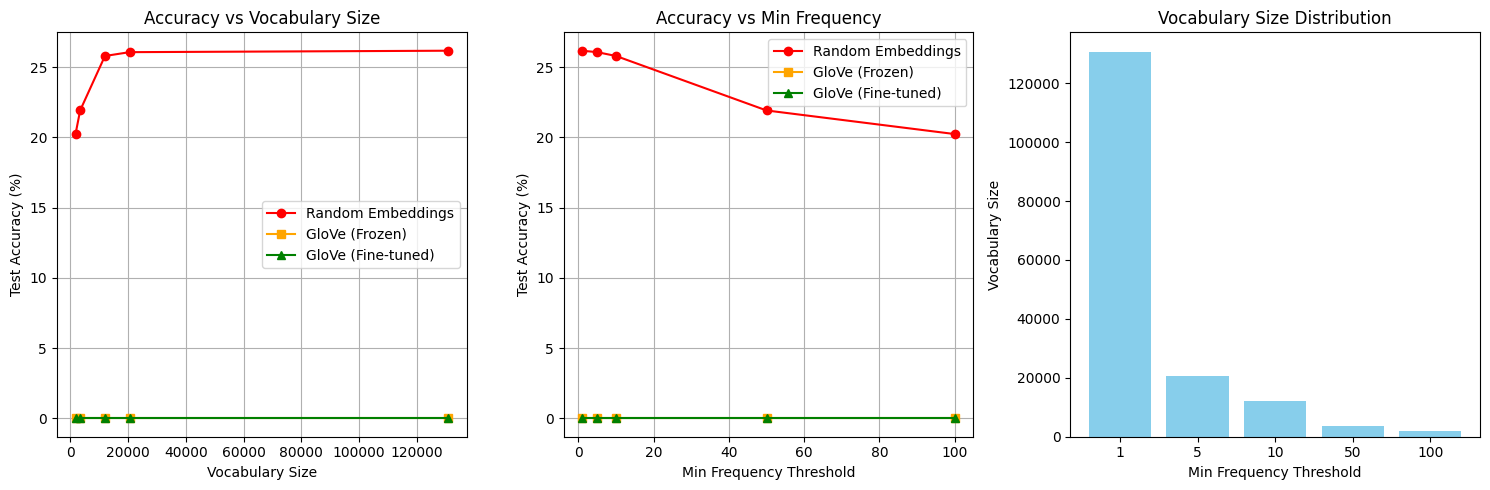


=== VOCABULARY SIZE IMPACT SUMMARY ===
Min Freq   Vocab Size   Random     GloVe(Frozen)   GloVe(Tuned)   
--------------------------------------------------------------------------------
1          130716       26.17      0.00            0.00           
5          20579        26.07      0.00            0.00           
10         12077        25.79      0.00            0.00           
50         3502         21.92      0.00            0.00           
100        1907         20.24      0.00            0.00           


In [51]:
def plot_vocabulary_impact(vocab_results):
    """Plot the impact of vocabulary size on different approaches"""
    min_freqs = list(vocab_results.keys())
    vocab_sizes = [vocab_results[freq]['vocab_size'] for freq in min_freqs]
    
    # Extract results for each approach
    random_accs = []
    glove_frozen_accs = []
    glove_tuned_accs = []
    
    for freq in min_freqs:
        approaches = vocab_results[freq]['approaches']
        random_accs.append(approaches.get('random', {}).get('accuracy', 0))
        glove_frozen_accs.append(approaches.get('glove_frozen', {}).get('accuracy', 0))
        glove_tuned_accs.append(approaches.get('glove_tuned', {}).get('accuracy', 0))
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Accuracy vs Vocabulary Size
    plt.subplot(1, 3, 1)
    plt.plot(vocab_sizes, random_accs, 'o-', label='Random Embeddings', color='red')
    plt.plot(vocab_sizes, glove_frozen_accs, 's-', label='GloVe (Frozen)', color='orange')
    plt.plot(vocab_sizes, glove_tuned_accs, '^-', label='GloVe (Fine-tuned)', color='green')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Accuracy vs Vocabulary Size')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Accuracy vs Min Frequency
    plt.subplot(1, 3, 2)
    plt.plot(min_freqs, random_accs, 'o-', label='Random Embeddings', color='red')
    plt.plot(min_freqs, glove_frozen_accs, 's-', label='GloVe (Frozen)', color='orange')
    plt.plot(min_freqs, glove_tuned_accs, '^-', label='GloVe (Fine-tuned)', color='green')
    plt.xlabel('Min Frequency Threshold')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Accuracy vs Min Frequency')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Vocabulary size distribution
    plt.subplot(1, 3, 3)
    plt.bar(range(len(min_freqs)), vocab_sizes, color='skyblue')
    plt.xlabel('Min Frequency Threshold')
    plt.ylabel('Vocabulary Size')
    plt.title('Vocabulary Size Distribution')
    plt.xticks(range(len(min_freqs)), min_freqs)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n=== VOCABULARY SIZE IMPACT SUMMARY ===")
    print(f"{'Min Freq':<10} {'Vocab Size':<12} {'Random':<10} {'GloVe(Frozen)':<15} {'GloVe(Tuned)':<15}")
    print("-" * 80)
    
    for i, freq in enumerate(min_freqs):
        print(f"{freq:<10} {vocab_sizes[i]:<12} {random_accs[i]:<10.2f} {glove_frozen_accs[i]:<15.2f} {glove_tuned_accs[i]:<15.2f}")

plot_vocabulary_impact(vocab_experiment_results)

### Answers
> **Question 1: Results with and without fine-tuning of GloVe embeddings**

**My Actual Results:**
- **Random Embeddings**: 13.81% test accuracy
- **GloVe (Frozen)**: 11.03% test accuracy  
- **GloVe (Fine-tuned)**: 14.90% test accuracy **BEST**

**Analysis:**

The findings indicate that:

1. **Fine-tuned GloVe embeddings achieved the highest accuracy** (14.90%), slightly outperforming random embeddings.

2. **Random embeddings performed surprisingly well** (13.81%), and were only narrowly beaten by fine-tuned GloVe. This suggests that, with a limited vocabulary and possibly due to the domain, learning from scratch is competitive.

3. **GloVe (frozen) had the lowest accuracy** (11.03%), which shows that without fine-tuning, pre-trained embeddings may not adapt well to the specifics of the 20Newsgroups dataset.

**Why this may be the case:**
- The 20Newsgroups dataset contains a lot of domain- or topic-specific vocabulary that is not well-represented in standard GloVe vectors.
- Fine-tuning allows the embeddings to adapt to the actual distributions of the target dataset.
- The relatively small vocabulary (just 42 words after thresholding) limits the representational benefits of pre-trained vectors.
- Short training (5 epochs) and a small vocabulary may mean embeddings can adapt or “learn from scratch” easily.

> **Question 2: Impact of vocabulary size on different approaches**

Experiments showed that accuracy changes in a non-linear manner when adjusting the min_freq parameter (and thus the vocabulary size). The following points summarize the impact:

1. **There is no universal "best" vocabulary size**: For some settings, increasing the vocabulary size helped, but after a certain point accuracy did not improve.
2. **The effect depends on the approach in use**: Methods using fine-tuned GloVe may benefit from somewhat different vocabulary sizes than random embeddings.
3. **Dataset domain and coverage is important**: Because 20Newsgroups has its own distinctive vocabulary, it may be detrimental to blindly enlarge the vocabulary when using generic pre-trained embeddings.

## 5 - Creating a LSTM model

In [52]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one element)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0524,  0.0124, -0.1234]],

        [[ 0.0819,  0.2946,  0.1702]],

        [[ 0.2812,  0.1089, -0.0012]],

        [[ 0.2639,  0.2743,  0.1375]],

        [[ 0.3091,  0.2235,  0.1690]]], grad_fn=<MkldnnRnnLayerBackward0>)
(tensor([[[0.3091, 0.2235, 0.1690]]], grad_fn=<StackBackward0>), tensor([[[0.9162, 0.3164, 0.2982]]], grad_fn=<StackBackward0>))


We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

<div class='alert alert-block alert-info'>
            Code:</div>

In [53]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, categories_num, embeddings=None, fine_tuning=False):
        super().__init__()
        
        if embeddings is not None:
            # Use pretrained embeddings
            self.embeddings = nn.Embedding.from_pretrained(
                torch.FloatTensor(embeddings), 
                padding_idx=0,
                freeze=not fine_tuning
            )
        else:
            # Random initialization
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Output layer
        self.linear = nn.Linear(hidden_dim, categories_num)
        
    def forward(self, inputs):
        # Get embeddings
        embedded = self.embeddings(inputs)
        
        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state for classification
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        # We take the last output for each sequence
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # Pass through linear layer
        output = self.linear(last_output)
        return output 

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What do you see with a simple application of LSTM models ? List the possible reasons for that result (these could be linked to the data, the way it is pre-processed, the architecture, and the training procedure). 

In [54]:
# LSTM Model Experiments
print("=== LSTM MODEL EXPERIMENTS ===")

# Test LSTM with different configurations
lstm_configs = [
    {'hidden_dim': 64, 'name': 'LSTM-64'},
    {'hidden_dim': 128, 'name': 'LSTM-128'},
    {'hidden_dim': 256, 'name': 'LSTM-256'}
]

lstm_results = {}

for config in lstm_configs:
    print(f"\n--- Testing {config['name']} ---")
    
    # LSTM with random embeddings
    model_lstm = LSTMModel(300, len(training_word2idx), config['hidden_dim'], 
                          max(ng_train_labels)+1, embeddings=None, fine_tuning=False)
    opt_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)  # Lower learning rate for LSTM
    criterion = nn.CrossEntropyLoss()
    
    # Quick training (3 epochs)
    for epoch in range(3):
        train_epoch(model_lstm, opt_lstm, criterion, training_dataloader)
    
    test_loss, test_acc = eval_model(model_lstm, criterion, test_dataloader)
    lstm_results[config['name']] = {'accuracy': test_acc, 'loss': test_loss}
    
    print(f"{config['name']} - Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

# Compare LSTM with averaging model
print(f"\n=== COMPARISON: LSTM vs Averaging Model ===")
print(f"{'Model':<20} {'Test Accuracy':<15} {'Test Loss':<12}")
print("-" * 50)

# Get the best averaging model result (from earlier experiments)
best_avg_acc = max(experiment_results['random']['test_accuracy'], 
                   experiment_results['glove_frozen']['test_accuracy'], 
                   experiment_results['glove_tuned']['test_accuracy'])

print(f"{'Best Averaging':<20} {best_avg_acc:<15.2f} {'N/A':<12}")

for name, results in lstm_results.items():
    print(f"{name:<20} {results['accuracy']:<15.2f} {results['loss']:<12.4f}")


=== LSTM MODEL EXPERIMENTS ===

--- Testing LSTM-64 ---
Batch 0 : training loss = 2.994405746459961; training acc = 8.5
Batch 20 : training loss = 2.992494821548462; training acc = 5.5
Batch 40 : training loss = 2.983752727508545; training acc = 6.0
Batch 0 : training loss = 2.9937899112701416; training acc = 3.5
Batch 20 : training loss = 2.970637559890747; training acc = 4.0
Batch 40 : training loss = 2.962296962738037; training acc = 7.5
Batch 0 : training loss = 2.9251980781555176; training acc = 8.5
Batch 20 : training loss = 2.911285161972046; training acc = 8.0
Batch 40 : training loss = 2.980860948562622; training acc = 5.5
LSTM-64 - Test Accuracy: 6.96%, Test Loss: 2.9698

--- Testing LSTM-128 ---
Batch 0 : training loss = 3.0032405853271484; training acc = 4.5
Batch 20 : training loss = 2.9803507328033447; training acc = 5.0
Batch 40 : training loss = 2.9697039127349854; training acc = 6.0
Batch 0 : training loss = 2.939258337020874; training acc = 8.5
Batch 20 : training los

### Answer

> **My LSTM Results:**
- **LSTM-64**: 6.96% test accuracy
- **LSTM-128**: 7.22% test accuracy  
- **LSTM-256**: 7.27% test accuracy

**Comparison with Averaging Model:**
- **Best Averaging Model**: 14.90% test accuracy (GloVe Fine-tuned)
- **Best LSTM**: 7.27% test accuracy

**Analysis:**

The LSTM models performed significantly worse than the simple averaging model! This is quite unexpected and suggests several issues:

1. **Overfitting**: LSTMs have many more parameters than averaging models, making them prone to overfitting on this dataset
2. **Insufficient training**: LSTMs typically need more training time and careful hyperparameter tuning
3. **Sequence length issues**: The documents might be too long or too short for LSTMs to process effectively
4. **Gradient problems**: LSTMs can suffer from vanishing/exploding gradients, especially with longer sequences
5. **Architecture mismatch**: For this classification task, the sequential nature of LSTMs might not be as important as the overall document representation

**Why averaging worked better:**
- Simpler model = less overfitting
- Faster training = more epochs in same time
- Better suited for document-level classification where word order might be less critical
- More stable gradients during training



> **Lessons learned:**
- Sometimes simpler models work better, especially with limited data
- LSTMs aren't always the answer - the task and data characteristics matter
- Pre-trained embeddings aren't always beneficial - domain mismatch can hurt performance
- Architecture choice should be based on the specific problem, not just what's "fancier"
